### purpose

calculate performance from AF models evaluated at the individual level

<a id='home'></a>
### purpose

calculate performance from AF models evaluated at the individual level

### outline

1. [get metadata](#meta)
1. [get predicted offset files](#pred)
1. [calculate ind-level performance of AF models](#calc)
1. [sanity check](#sanity)

In [86]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt
import MVP_summary_functions as mvp

lview, dview = get_client(cluster_id='1713789842-5kaz', profile='lotterhos')

fig_dir = makedir(f'{rt.resdir}/figures/06_af_ind_performance')

t0 = dt.now()

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	April 22, 2024 - 16:34:52 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 8b790072e7a46d7f58a30c40cf4660986a612764  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 2 13:55:49 2024 -0500

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='meta'></a>
# get metadata
    
[top](#home)

In [6]:
len(rt.seeds)

540

In [7]:
# the 1-trait seeds that were ran as 1-trait 1-nuisance (used in cell #5)
params = mvp.read_params_file()

bad_seeds = set(params.seed.iloc[:675].astype(str)) - set(rt.seeds)

len(bad_seeds)

100%|███████████████| 2250/2250 [00:02<00:00, 793.14it/s]


135

In [8]:
assert len(bad_seeds) + len(rt.seeds) == 675

<a id='pred'></a>
# get predicted offset files

[top](#home)

In [9]:
pkls = []
for rep, repdirs in rt.dirs['pooled'].items():
    for repdir in repdirs:
        
        pkldir = f'{repdir}/gradient_forests/validation/offset_dfs'
        
        if op.exists(pkldir):
            pkl_files = fs(pkldir, endswith='.pkl', exclude=bad_seeds)
            
            pkls.extend(
                pkl_files
            )
            
            print(rep, op.basename(repdir), len(pkl_files))
        else:
            print(ColorText(f'{rep} {op.basename(repdir)} 0').fail().bold())
        
len(pkls)

run_20220919_0-225 00500 180
run_20220919_0-225 05000 180
run_20220919_0-225 10000 180
run_20220919_0-225 20000 180
run_20220919_225-450 00500 180
run_20220919_225-450 05000 180
run_20220919_225-450 10000 180
run_20220919_225-450 20000 180
run_20220919_450-675 00500 180
run_20220919_450-675 05000 180
run_20220919_450-675 10000 180
run_20220919_450-675 20000 180


2160

<a id='calc'></a>
# calculate ind-level performance

[top](#home)

In [67]:
def create_af_ind_offset(df, popsamps):
    """For an pop-level offset dataframe (100 rows x 100 cols), make it 100 rows x 1000 cols.
    
    Parameters
    ----------
    df : pandas.DataFrame
        - 100 rows (transplant locations) and 100 columns (genetic source)
        - entries are from allele frequency models (AF, pop)
        
    popsamps : dict
        - key = pop, value = list of sample names
    """
    import pandas as pd
    from collections import defaultdict
    
    new_df = defaultdict(dict)
    for pop, samps in popsamps.items():
        for samp in samps:  # replicate the population-level offset for each individual
            new_df[samp] = df[pop]
    
    new_df = pd.DataFrame(new_df)
    
    return new_df

def assert_same(offset, fitness):
    """Make sure dataframes are consistent."""
    assert all(offset.columns.isin(fitness.columns))
    assert all(offset.index.isin(fitness.index))
    assert offset.shape == fitness.shape
    
    pass

def recalc_performance(pkl):
    """Recalc performance using AF,pop offsets and ind-level fitness."""
    from pythonimports import pklload
    import MVP_summary_functions as mvp
    import MVP_01_train_gradient_forests as mvp01
    import MVP_03_validate_gradient_forests as mvp03
    import MVP_06_validate_RONA as mvp06
    import runtime_API as rt

    from os import path as op

    # get simulation replicate ID
    seed = op.basename(pkl).split("_")[0]

    # get individual and population info
    subset = mvp01.read_ind_data(mvp.slimdir, seed)
    subset.subpopID = subset.subpopID.astype(str)
    subset.indID = subset.indID.astype(str)  # to match columns in offset df

    # map individual IDs to population IDs - key = popID value = list of indIDs
    popsamps = subset.groupby('subpopID')['indID'].apply(list).to_dict()

    # load AF,pop offset
    pooled_offset = pklload(pkl)['pooled']['all']  # marker set key is 'all' for the runtime project, no matter num_loci

    # duplicate pooled offsets for each individual in population
    af_ind_offset = create_af_ind_offset(pooled_offset, popsamps)

    # get fitness data (from MVP_03.main)
    fitness_mat = {
        'ind': mvp03.load_ind_fitness_matrix(mvp.slimdir, seed, subset),
        'pooled': mvp06.load_pooled_fitness_matrix(mvp.slimdir, seed)
    }

    # calculate af,ind perforance
    assert_same(af_ind_offset, fitness_mat['ind'])
    perf = af_ind_offset.corrwith(
        fitness_mat['ind'],
        axis='columns',
        method='kendall'
    )
    
    # get the actual AF,pop performance
    assert_same(pooled_offset, fitness_mat['pooled'])
    perf_af = pooled_offset.corrwith(
        fitness_mat['pooled'],
        axis='columns',
        method='kendall'
    )

    return perf, perf_af

dview['create_af_ind_offset'] = create_af_ind_offset
dview['assert_same'] = assert_same

#### test function

In [52]:
pkls[0]

'/work/lotterhos/brandon/pooled_runtimes/run_20220919_0-225/00500/gradient_forests/validation/offset_dfs/1231109_offset_dfs.pkl'

In [68]:
perf, perf_af = recalc_performance(pkls[0])


Reading in info for subsampled individuals ...


In [69]:
rt.factor_names['pooled']

'$\\it{GO}_{AF, pop}$'

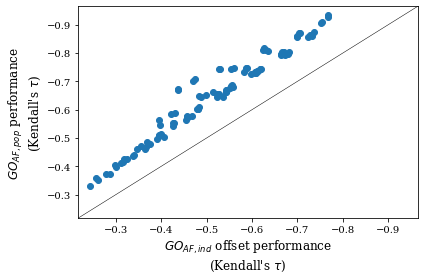

In [75]:
ax = plt.scatter(perf, perf_af)

mf.draw_xy(ax.axes)

ax.axes.invert_yaxis()
ax.axes.invert_xaxis()

ax.axes.set_xlabel("$\\it{GO}_{AF,ind}$ offset performance\n(Kendall's $\\tau$)", fontsize=12)
ax.axes.set_ylabel(f"{rt.factor_names['pooled']} performance\n(Kendall's $\\tau$)", fontsize=12)

plt.tight_layout()

### calc in parallel

In [76]:
jobs = []
for pkl in pkls:
    jobs.append(
        lview.apply_async(
            recalc_performance, pkl
        )
    )
    
watch_async(jobs)


Watching 2160 jobs ...


100%|███████████████| 2160/2160 [00:48<00:00, 44.35it/s]


### retrieve results

In [77]:
@timer
def annotate_jobs(jobs, idx=0):
    """Annotate the either of the two outputs from recalc_performance."""
    if idx == 0:
        source = 'af,ind'
    else:
        source = 'ind'
    
    res = []
    for i, j in enumerate(pbar(jobs)):
        pkl = pkls[i]

        perf = j.r[idx].reset_index()

        perf.columns = ['garden', 'score']

        perf['seed'] = op.basename(pkl).split("_")[0]
        perf['num_loci'] = pkl.split("/")[6].lstrip('0')
        perf['rep'] = pkl.split("/")[5].split("_")[-1]

        res.append(perf)

    # combine
    _results = pd.concat(res).reset_index(drop=True)

    # add metadata
    for param in params.columns[-9:-1]:
        _results[param] = _results.seed.astype(str).map(params[param])

    _results['simulation_level'] = _results[_results.columns[6:]].apply(
        lambda x: '_'.join(x.astype(str)), axis=1
    )

    _results['offset_level'] = _results[['simulation_level', 'rep', 'num_loci', 'garden']].apply(
        lambda x: '_'.join(x.astype(str)), axis=1
    )

    _results.index = _results.offset_level.tolist()
    
    _results['source'] = source

    return _results


afind_results = annotate_jobs(jobs, idx=0)
pooled_results = annotate_jobs(jobs, idx=1)

100%|███████████████| 2160/2160 [00:02<00:00, 830.82it/s]


Function `annotate_jobs` completed after : 0-00:00:23


100%|███████████████| 2160/2160 [00:02<00:00, 736.70it/s]


Function `annotate_jobs` completed after : 0-00:00:23


In [82]:
afind_results.head()

,garden,score,seed,num_loci,rep,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,offset_level,source
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_1,1,-0.551398,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,"af,ind"
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_2,2,-0.611882,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,"af,ind"
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_3,3,-0.673033,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,"af,ind"
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_4,4,-0.723169,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,"af,ind"
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_5,5,-0.753114,1231109,500,0-225,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,highly-polygenic_2-trait_no pleiotropy_equal-S...,"af,ind"


### save 

no need to save `pooled_results` since it's the same as what I have in `rt.load_results()["pooled"]`

In [87]:
f = f'{fig_dir}/af_ind_results.txt'

afind_results.to_csv(f, sep='\t', index=False)  # index is offset_level column

f

'/work/lotterhos/brandon/runtime/figures/06_af_ind_performance/af_ind_results.txt'

Saved to:  /work/lotterhos/brandon/runtime/figures/06_af_ind_performance/af-ind_af-pop_scatter2d.pdf


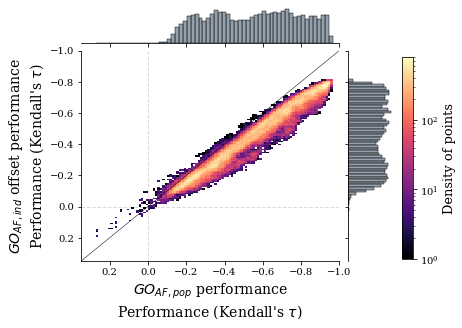

In [107]:
x = pooled_results
y = afind_results

ax = mf.scatter2d(
    x=x.score,
    y=y.score,
    cmap='magma',
    marginal_kws={'color' : 'slategray'},
    vlim=(1, 800)
).ax_joint

ax.axes.set_xlim((-1, 0.35))

mf.draw_xy(ax)

ax.invert_yaxis()
ax.invert_xaxis()

ax.axhline(0, **rt.hline_kwargs)
ax.axvline(0, **rt.hline_kwargs)

ax.set_ylabel(
    f"%s offset performance\n{rt.perf_label}" % "$\\it{GO}_{AF,ind}$",
    fontsize=14
)
ax.set_xlabel(
    f"{rt.factor_names['pooled']} performance\n{rt.perf_label}",
    fontsize=14
)

ax.set_title(None)

mf.save_pdf(f'{fig_dir}/af-ind_af-pop_scatter2d.pdf')

plt.show()

<a id='sanity'></a>
# sanity check

make sure my recalculated scores match the ones I already have saved

[top](#home)

In [90]:
# get previously saved individual-level results

# drop pop-level results
results = rt.load_results('pooled')  # all_results[all_results.source == 'pooled'].copy()
results.index = results.offset_level.tolist()

results

keeping records for models using 20k loci
pooled shape = (216000, 17)
Function `load_results` completed after : 0-00:00:21


,garden,score,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,simulation_level,rep,num_loci,seed,demography,source,offset_level,seed_garden,final_la_bin
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_1,1,-0.676768,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_1,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_2,2,-0.735758,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_2,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_3,3,-0.794747,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_3,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_4,4,-0.856566,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_4,0.42 < LA ≤ 0.58
highly-polygenic_2-trait_no pleiotropy_equal-S_Est-Clines_N-cline-center-to-edge_m-constant_0-225_500_5,5,-0.906263,0.501332,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,highly-polygenic_2-trait_no pleiotropy_equal-S...,0-225,500,1231109,N-cline-center-to-edge_m-constant,pooled,highly-polygenic_2-trait_no pleiotropy_equal-S...,1231109_5,0.42 < LA ≤ 0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_96,96,-0.323659,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,pooled,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_96,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_97,97,-0.311476,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,pooled,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_97,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_98,98,-0.297263,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,pooled,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_98,0.27 < LA ≤ 0.42
oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn_N-variable_m-variable_450-675_20000_99,99,-0.316349,0.382113,oligogenic,2-trait,pleiotropy,unequal-S,SS-Mtn,N-variable,m-variable,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,450-675,20000,1231768,N-variable_m-variable,pooled,oligogenic_2-trait_pleiotropy_unequal-S_SS-Mtn...,1231768_99,0.27 < LA ≤ 0.42


In [102]:
all(pooled_results.index.isin(results.index))

True

In [104]:
all(results.index.isin(pooled_results.index))

True

In [93]:
for method in ['pearson', 'spearman', 'kendall']:
    print(method, pooled_results.loc[results.index].score.corr(results.score, method=method))

pearson 1.0
spearman 1.0
kendall 1.0


In [95]:
# how far in do I have to round until I get the same answer? A: 14 decimal places
for round_at in range(20):
    print(
        round_at, 
        all(pooled_results.loc[results.index].score.round(round_at) == results.score.round(round_at))
    )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 False
15 False
16 False
17 False
18 False
19 False


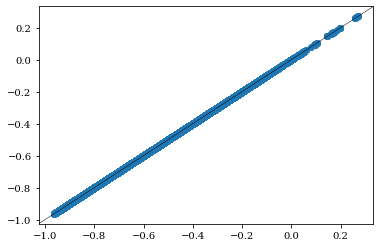

In [96]:
ax = plt.scatter(pooled_results.loc[results.index].score, results.score)

mf.draw_xy(ax.axes)

In [97]:
formatclock(dt.now() - t0)

'0-00:03:22'